In [1]:
# -*- coding: utf-8 -*-
# Create time: 2025-10-10
# Update time: 2025-11-27

# conda activate benchmark
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['svg.fonttype'] = 'none'

# cm 转 inch
cm_to_inch = 1 / 2.54

In [3]:

def plot_comparison_scatter(dataset_configs, metric='accuracy', type='Batch', figsize=(10, 8), save_dir=None):
    """
    绘制batch-centered前后probing结果的对比散点图
    
    Parameters:
    -----------
    dataset_configs : list of dict
        数据集配置列表，每个字典包含：
        - 'before_csv': batch-centered前分类结果CSV文件路径
        - 'after_csv': batch-centered后分类结果CSV文件路径  
        - 'title': 子图标题
        - 'vline': 纵向虚线位置 (可选)
        - 'hline': 横向虚线位置 (可选)
    metric : str
        指标名称 ('accuracy' 或 'f1_score')
    type : str
        分类类型（'Batch' 或 'Cell Type'）
    figsize : tuple
        图像大小
    save_dir : str, optional
        图片保存目录，如果为None则不保存图片
    """

    # 定义模型分类
    traditional_methods = ['PCA', 'Harmony', 'Scanorama', 'scVI']
    foundation_models = ['scCello', 'Nicheformer', 'scGPT', 'CellPLM', 'GeneCompass', 'scFoundation', 'Geneformer', 'UCE']
    
    # 定义颜色
    model_colors = {
        'Harmony': '#FF8E53', 
        'PCA': '#26C281',
        'Scanorama': '#FF6B6B',
        'scVI': '#4ECDC4',
        'UCE': '#FFA502',
        'Geneformer': '#2F3542',
        'CellPLM': '#FF4757',        
        'scGPT': '#45B7D1',
        'scFoundation': '#3742FA',
        'Nicheformer': '#A4B0BE',
        'scCello': "#DB45F9",
        'GeneCompass': "#B9CF0F",
    }
    
    
    # 定义形状
    shapes = {
        'Traditional methods': 'o',  # 圆形
        'Foundation models': 's'     # 方形
    }

    # 全局字体设置
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['font.size'] = 6
    plt.rc('lines', linewidth=0.5)  #  设置全局线宽

    n_datasets = len(dataset_configs)
    # 改成 2 行 3 列
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    
    # 将 axes 展平成一维列表方便遍历
    axes_flat = axes.flatten()
    
    # 用于收集所有模型信息（用于创建统一的图例）
    all_models_info = {}
    
    for idx in range(min(n_datasets, 6)):  # 最多处理6个数据集
        ax = axes_flat[idx]
        config = dataset_configs[idx]
        
        # 读取数据
        before_df = pd.read_csv(config['before_csv'])
        after_df = pd.read_csv(config['after_csv'])
        
        # 提取overall的mean结果
        before_overall = before_df[
            (before_df['dataset'] == 'overall') & 
            (before_df['fold'] == 'mean')
        ][['model_name', metric]].copy()
        before_overall.columns = ['model_name', f'before_{metric}']
        
        after_overall = after_df[
            (after_df['dataset'] == 'overall') & 
            (after_df['fold'] == 'mean')
        ][['model_name', metric]].copy()
        after_overall.columns = ['model_name', f'after_{metric}']
        
        # 合并数据
        merged_df = pd.merge(before_overall, after_overall, on='model_name', how='inner')
        
        # 添加模型分类列
        def classify_model(model_name):
            if model_name in traditional_methods:
                return 'Traditional methods'
            elif model_name in foundation_models:
                return 'Foundation models'
            else:
                return 'other'
        
        merged_df['model_type'] = merged_df['model_name'].apply(classify_model)
        
        # 筛选出 Foundation models
        merged_df = merged_df[merged_df['model_type'] == 'Foundation models']

        # 添加对角线虚线（y = x）
        ax.plot([0, 1.1], [0, 1.1], color='gray', linestyle='--', linewidth=0.75, alpha=0.7)
        
        # 添加用户指定的虚线
        if 'vline' in config and config['vline'] is not None:
            ax.axvline(x=config['vline'], color='red', linestyle='--', linewidth=0.75, alpha=0.5)
        
        if 'hline' in config and config['hline'] is not None:
            ax.axhline(y=config['hline'], color='red', linestyle='--', linewidth=0.75, alpha=0.5)
        
        # 绘制散点图
        for _, row in merged_df.iterrows():
            model_name = row['model_name']
            model_type = row['model_type']
            
            # 确定颜色
            if model_name in model_colors:
                color = model_colors[model_name]
            else:
                color = '#95A5A6'  # 默认灰色
            
            # 确定形状
            if model_type in shapes:
                marker = shapes[model_type]
            else:
                marker = '^'  # 默认三角形
            
            # 绘制点
            ax.scatter(row[f'after_{metric}'], row[f'before_{metric}'],
                      c=color, marker=marker, s=20, alpha=0.8, 
                      edgecolors='black', linewidth=0.5)
            
            # 收集模型信息用于图例（只收集一次，避免重复）
            if model_name not in all_models_info:
                all_models_info[model_name] = {
                    'color': color,
                    'marker': marker,
                    'type': model_type
                }
        
        # 设置坐标轴范围为0-1
        ax.set_xlim(0, 1.1)
        ax.set_ylim(0, 1.1)
        # 设置子图标题和标签
        metric_name = 'Accuracy' if metric == 'accuracy' else 'Macro-F1'
        ax.set_title(config['title'], fontsize=7, fontweight='bold')
        
        # 第五个图显示x轴标签
        if idx == 4:
            ax.set_xlabel(f'{type} Classification {metric_name} of Batch-centered Embedding', fontsize=7)
        
        
        # 坐标轴刻度大小
        ax.tick_params(axis='both', which='major', labelsize=5, width=0.5, pad=1, length=2)

        ax.grid(True, alpha=0.3)

        # 移除上方和右方框线
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # 隐藏多余的子图（如果少于 6 个数据集）
    for idx in range(n_datasets, 6):
        axes_flat[idx].axis('off')
    
    # 创建统一的图例
    legend_elements = []
    
    # 按模型类型和名称排序，确保顺序一致
    traditional_models_sorted = []
    foundation_models_sorted = []
    other_models_sorted = []
    
    for model_name, info in all_models_info.items():
        if info['type'] == 'Traditional methods':
            traditional_models_sorted.append((model_name, info))
        elif info['type'] == 'Foundation models':
            foundation_models_sorted.append((model_name, info))
        else:
            other_models_sorted.append((model_name, info))
    
    # 排序并添加到图例 - 先传统方法，后基础模型
    for model_name, info in sorted(traditional_models_sorted):
        legend_elements.append(plt.Line2D([0], [0], marker=info['marker'], color='w',
                                        markerfacecolor=info['color'], markersize=4,
                                        markeredgecolor='black', markeredgewidth=0.5,
                                        label=model_name, linestyle='None'))
    
    for model_name, info in sorted(foundation_models_sorted):
        legend_elements.append(plt.Line2D([0], [0], marker=info['marker'], color='w',
                                        markerfacecolor=info['color'], markersize=4,
                                        markeredgecolor='black', markeredgewidth=0.5,
                                        label=model_name, linestyle='None'))
    
    for model_name, info in sorted(other_models_sorted):
        legend_elements.append(plt.Line2D([0], [0], marker=info['marker'], color='w',
                                        markerfacecolor=info['color'], markersize=4,
                                        markeredgecolor='black', markeredgewidth=0.5,
                                        label=model_name, linestyle='None'))

    # 图例放在右侧一列展示
    fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.05, 0.5),
               frameon=False, handletextpad=0.1, fontsize=5)
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)  # 为右侧图例留出空间

    # 在整个图的左侧中间添加共享ylabel
    fig.text(0.01, 0.5, f'{metric_name} of Raw Embedding', 
             va='center', ha='center', rotation='vertical', fontsize=7)
    

    # 保存图像
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, f"FigureS15_batch_normalize_probing_{type}_{metric}.pdf"), bbox_inches="tight")
        plt.savefig(os.path.join(save_dir, f"FigureS15_batch_normalize_probing_{type}_{metric}.svg"), bbox_inches="tight")
        plt.savefig(os.path.join(save_dir, f"FigureS15_batch_normalize_probing_{type}_{metric}.jpg"), dpi=600, bbox_inches="tight")

    plt.show()
    
    return None



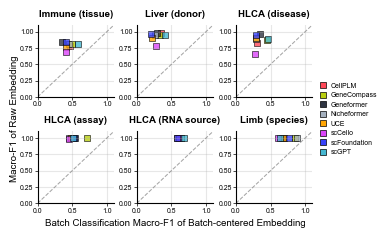

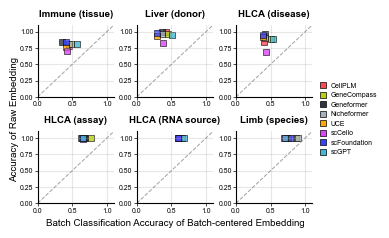

In [4]:
dataset_configs = [
    {
        'before_csv': "/home/wanglinting/scFM/Result/Immune/probing/batch/cv_results_summary.csv", 
        'after_csv': "/home/wanglinting/scFM/Result/Immune_batch_normalize/probing/batch/cv_results_summary.csv",
        'title': 'Immune (tissue)',
    },
    {
        'before_csv': "/home/wanglinting/scFM/Result/liver/probing/batch/cv_results_summary.csv", 
        'after_csv': "/home/wanglinting/scFM/Result/liver_batch_normalize/probing/batch/cv_results_summary.csv",
        'title': 'Liver (donor)',
    },
    {
        'before_csv': "/home/wanglinting/scFM/Result/HLCA_disease/probing/batch/cv_results_summary.csv", 
        'after_csv': "/home/wanglinting/scFM/Result/HLCA_disease_batch_normalize/probing/batch/cv_results_summary.csv",
        'title': 'HLCA (disease)',
    },
    {
        'before_csv': "/home/wanglinting/scFM/Result/HLCA_assay/probing/batch/cv_results_summary.csv",
        'after_csv': "/home/wanglinting/scFM/Result/HLCA_assay_batch_normalize/probing/batch/cv_results_summary.csv",
        'title': 'HLCA (assay)',
    },
    {
        'before_csv': "/home/wanglinting/scFM/Result/HLCA_sn/probing/batch/cv_results_summary.csv",
        'after_csv': "/home/wanglinting/scFM/Result/HLCA_sn_batch_normalize/probing/batch/cv_results_summary.csv",
        'title': 'HLCA (RNA source)',
    },
    {
        'before_csv': "/home/wanglinting/scFM/Result/limb/probing/batch/cv_results_summary.csv",
        'after_csv': "/home/wanglinting/scFM/Result/limb_batch_normalize/probing/batch/cv_results_summary.csv",
        'title': 'Limb (species)',
    },

]

plot_comparison_scatter(
    dataset_configs,
    metric='f1_score',
    type='Batch',
    figsize=(9*cm_to_inch, 6*cm_to_inch),
    save_dir="/home/wanglinting/scFM/Result/figure/probing"
)

plot_comparison_scatter(
    dataset_configs,
    metric='accuracy',
    type='Batch',
    figsize=(9*cm_to_inch, 6*cm_to_inch),
    save_dir="/home/wanglinting/scFM/Result/figure/probing"
)

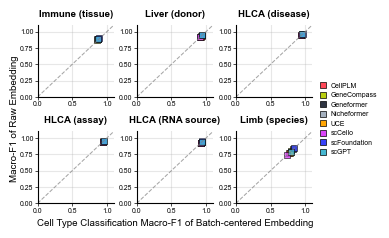

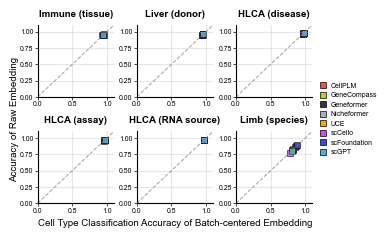

In [5]:
dataset_configs = [
    {
        'before_csv': "/home/wanglinting/scFM/Result/Immune/probing/celltype/cv_results_summary.csv", 
        'after_csv': "/home/wanglinting/scFM/Result/Immune_batch_normalize/probing/celltype/cv_results_summary.csv",
        'title': 'Immune (tissue)',
    },
    {
        'before_csv': "/home/wanglinting/scFM/Result/liver/probing/celltype/cv_results_summary.csv", 
        'after_csv': "/home/wanglinting/scFM/Result/liver_batch_normalize/probing/celltype/cv_results_summary.csv",
        'title': 'Liver (donor)',
    },
    {
        'before_csv': "/home/wanglinting/scFM/Result/HLCA_disease/probing/celltype/cv_results_summary.csv", 
        'after_csv': "/home/wanglinting/scFM/Result/HLCA_disease_batch_normalize/probing/celltype/cv_results_summary.csv",
        'title': 'HLCA (disease)',
    },
    {
        'before_csv': "/home/wanglinting/scFM/Result/HLCA_assay/probing/celltype/cv_results_summary.csv",
        'after_csv': "/home/wanglinting/scFM/Result/HLCA_assay_batch_normalize/probing/celltype/cv_results_summary.csv",
        'title': 'HLCA (assay)',
    },
    {
        'before_csv': "/home/wanglinting/scFM/Result/HLCA_sn/probing/celltype/cv_results_summary.csv",
        'after_csv': "/home/wanglinting/scFM/Result/HLCA_sn_batch_normalize/probing/celltype/cv_results_summary.csv",
        'title': 'HLCA (RNA source)',
    },
    {
        'before_csv': "/home/wanglinting/scFM/Result/limb/probing/celltype/cv_results_summary.csv",
        'after_csv': "/home/wanglinting/scFM/Result/limb_batch_normalize/probing/celltype/cv_results_summary.csv",
        'title': 'Limb (species)',
    },

]

plot_comparison_scatter(
    dataset_configs,
    metric='f1_score',
    type='Cell Type',
    figsize=(9*cm_to_inch, 6*cm_to_inch),
    save_dir="/home/wanglinting/scFM/Result/figure/probing"
)

plot_comparison_scatter(
    dataset_configs,
    metric='accuracy',
    type='Cell Type',
    figsize=(9*cm_to_inch, 6*cm_to_inch),
    save_dir="/home/wanglinting/scFM/Result/figure/probing"
)